In [1]:
import pandas as pd
from pathlib import Path
import pickle as pkl
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
pd.options.display.float_format = '{:.5f}'.format

In [2]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [3]:
DIR = "/raid5pool/tank/luehring/german_newsguard_tweets/"
DATA_DIR = join(DIR, "discussions/")
OUPUT_DIR = "../matching/"
FIG_DIR = "../../../emomis-discussion-paper/figures/"
with open(join(DIR, "dtypes_config.pickle"), "rb") as file:
    DTYPES = pkl.load(file)

In [4]:
def read_data(data_dir, pattern):
    for file_path in Path(data_dir).glob(pattern):
        try:
            print(f"Processing file: {file_path}")
            df = pd.read_csv(file_path, dtype=DTYPES)
            df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
            df["Bias"] = pd.to_numeric(df["Orientation"], errors="coerce")
            df.drop(columns=["Orientation"], inplace=True)
            df.drop(columns=["Unnamed: 0"], inplace=True)
            df.columns = df.columns.str.replace("author.", "")
            return df
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
replies = read_data(DATA_DIR, "matched_replies_mahalanobis_log.csv")
first = read_data(DATA_DIR, "matched_replies_first_mahalanobis_log.csv")
replies.shape, first.shape

Processing file: /raid5pool/tank/luehring/german_newsguard_tweets/discussions/matched_replies_mahalanobis_log.csv


/tmp/ipykernel_829184/4213886871.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("author.", "")


Processing file: /raid5pool/tank/luehring/german_newsguard_tweets/discussions/matched_replies_first_mahalanobis_log.csv


/tmp/ipykernel_829184/4213886871.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("author.", "")


((77318, 25), (77318, 42))

In [5]:
first.columns

Index(['conversation_id', 'domain', 'id', 'created_at', 'followers_count',
       'following_count', 'tweet_count', 'Rating', 'Score', 'anger', 'fear',
       'disgust', 'sadness', 'joy', 'pride', 'hope', 'word_count',
       'word_count_log', 'tweet_count_log', 'followers_count_log',
       'following_count_log', 'anger_log', 'fear_log', 'disgust_log',
       'sadness_log', 'joy_log', 'pride_log', 'hope_log', 'id', 'first_id',
       'anger_first', 'fear_first', 'disgust_first', 'sadness_first',
       'joy_first', 'pride_first', 'hope_first', 'tweet_count_first',
       'tweet_count_first_log', 'weights', 'subclass', 'Bias'],
      dtype='object')

In [6]:
IV = "Rating"
DVS = ["anger_avg", "disgust_avg", "fear_avg", "sadness_avg", 
       "joy_avg", "pride_avg", "hope_avg"]
COVARIATES = ["Bias", 
              "followers_count_log", "following_count_log", "tweet_count_log",
              "word_count_log", 
              "tweet_count_avg_log", "time_diff_log"]
DVS_FIRST =  ["anger_first", "disgust_first", "fear_first", "sadness_first", 
              "joy_first", "pride_first", "hope_first"]
COVARIATES_FIRST = ["Bias",
                       "followers_count_log", "following_count_log", "tweet_count_log",
                       "word_count_log", 
                       "tweet_count_first_log"]

In [7]:
def process_coeffs(path):
    coeffs = pd.read_csv(path)
    coeffs["DV"] = coeffs["DV"].str.replace("_avg", "")\
                                .str.replace("_first", "")
    coeffs["Change"] = (coeffs["Coefficient"] / coeffs["Cond_Mean"]) * 100
    
    coeffs = coeffs.rename(
        columns={"P-Value": "p",
                 "R-Squared": "R²",
                 "Coefficient": "Estimate"})

    coeffs.drop(columns="Cond_Mean", inplace=True)
    
    return coeffs

replies_coeffs = process_coeffs("./replies/replies_coeffs.csv")
first_coeffs = process_coeffs("./replies/replies_first_coeffs.csv")
replies_coeffs.head()

,DV,Estimate,SE,CI_Lower,CI_Upper,p,R²,Change
0,Anger,0.03132,0.00243,0.02655,0.03608,0.00000,0.01552,8.49592
1,Disgust,0.00359,0.00058,0.00246,0.00472,0.00000,0.00565,20.87391
2,Fear,0.00185,0.00052,0.00082,0.00288,0.00042,0.00575,12.30678
3,Sadness,0.00092,0.00058,-0.00021,0.00206,0.10908,0.01328,5.24677
4,Joy,-0.00361,0.00087,-0.00531,-0.00191,0.00003,0.00808,-11.27501


In [8]:
def process_boot(path):
    boot = pd.read_csv(path)
    boot["DV"] = boot["DV"].str.replace("_avg", "")\
                            .str.replace("_first", "")
    
    quantiles = boot.groupby("DV")["Coefficient_boot"]\
    .agg(
        CI_Lower_boot=lambda x: x.quantile(0.025),  # 2.5th percentile
        CI_Upper_boot=lambda x: x.quantile(0.975),  # 97.5th percentile
        )\
    .reset_index()
    return boot, quantiles

replies_coeffs_boot, replies_cis = process_boot("./replies/replies_coeffs_boot.csv")
first_coeffs_boot, first_cis = process_boot("./replies/replies_first_coeffs_boot.csv")
replies_coeffs_boot

,DV,Coefficient_boot,CI_Lower_boot,CI_Upper_boot,P-Value_boot,R-Squared_boot
0,Anger,0.03133,0.02656,0.03609,0.00000,0.01577
1,Anger,0.03367,0.02890,0.03844,0.00000,0.01638
2,Anger,0.03359,0.02881,0.03836,0.00000,0.01383
3,Anger,0.03204,0.02730,0.03678,0.00000,0.01571
4,Anger,0.02830,0.02354,0.03306,0.00000,0.01536
...,...,...,...,...,...,...
139995,Hope,-0.00074,-0.00148,0.00001,0.05430,0.00216
139996,Hope,-0.00082,-0.00153,-0.00011,0.02444,0.00218
139997,Hope,-0.00037,-0.00108,0.00034,0.30889,0.00235
139998,Hope,0.00002,-0.00070,0.00074,0.95639,0.00238


In [9]:
# merge with coefficients
replies_coeffs = replies_coeffs.merge(replies_cis, on="DV")
first_coeffs = first_coeffs.merge(first_cis, on="DV")
replies_coeffs

,DV,Estimate,SE,CI_Lower,CI_Upper,p,R²,Change,CI_Lower_boot,CI_Upper_boot
0,Anger,0.03132,0.00243,0.02655,0.03608,0.00000,0.01552,8.49592,0.02653,0.03613
1,Disgust,0.00359,0.00058,0.00246,0.00472,0.00000,0.00565,20.87391,0.00246,0.00473
2,Fear,0.00185,0.00052,0.00082,0.00288,0.00042,0.00575,12.30678,0.00082,0.00286
3,Sadness,0.00092,0.00058,-0.00021,0.00206,0.10908,0.01328,5.24677,-0.00021,0.00203
4,Joy,-0.00361,0.00087,-0.00531,-0.00191,0.00003,0.00808,-11.27501,-0.00529,-0.00193
5,Pride,-0.00032,0.00026,-0.00083,0.00019,0.22073,0.00133,-6.07956,-0.00083,0.00020
6,Hope,-0.00008,0.00037,-0.00080,0.00063,0.81903,0.00157,-1.11807,-0.00082,0.00065


In [10]:
# format for latex table
def format_latex(coeffs):
    numeric_cols = coeffs.select_dtypes(include=['float', 'int']).columns
    coeffs[numeric_cols] = coeffs[numeric_cols].applymap("{:.3f}".format)
    coeffs["95\%CI"] = coeffs["CI_Lower_boot"] + ", " + coeffs["CI_Upper_boot"]
    coeffs.drop(columns=["CI_Lower", "CI_Upper", "CI_Lower_boot", "CI_Upper_boot"], inplace=True)
    coeffs = coeffs[["DV", "Estimate", "95\%CI", "p", "R²", "Change"]]
    return coeffs

replies_latex = format_latex(replies_coeffs)
first_latex = format_latex(first_coeffs)
replies_latex

,DV,Estimate,95\%CI,p,R²,Change
0,Anger,0.031,"0.027, 0.036",0.000,0.016,8.496
1,Disgust,0.004,"0.002, 0.005",0.000,0.006,20.874
2,Fear,0.002,"0.001, 0.003",0.000,0.006,12.307
3,Sadness,0.001,"-0.000, 0.002",0.109,0.013,5.247
4,Joy,-0.004,"-0.005, -0.002",0.000,0.008,-11.275
5,Pride,-0.000,"-0.001, 0.000",0.221,0.001,-6.080
6,Hope,-0.000,"-0.001, 0.001",0.819,0.002,-1.118


In [11]:
# save as latex table
replies_latex.to_latex(join(
    FIG_DIR, "../tables/replies_coeffs.tex"), 
    index=False)
first_latex.to_latex(join(
    FIG_DIR, "../tables/first_coeffs.tex"), 
    index=False)

/tmp/ipykernel_829184/3586140400.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  replies_latex.to_latex(join(
/tmp/ipykernel_829184/3586140400.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  first_latex.to_latex(join(


In [12]:
# take the median coefficient for each DV
replies_boot_median = replies_coeffs_boot.groupby("DV").median().reset_index()
replies_boot_median

,DV,Coefficient_boot,CI_Lower_boot,CI_Upper_boot,P-Value_boot,R-Squared_boot
0,Anger,0.03133,0.02657,0.03610,0.00000,0.01570
1,Disgust,0.00359,0.00246,0.00472,0.00000,0.00582
2,Fear,0.00185,0.00082,0.00288,0.00042,0.00594
3,Hope,-0.00008,-0.00080,0.00063,0.48641,0.00173
4,Joy,-0.00360,-0.00530,-0.00190,0.00003,0.00830
5,Pride,-0.00032,-0.00083,0.00019,0.21588,0.00156
6,Sadness,0.00091,-0.00021,0.00205,0.11205,0.01347


In [13]:
first_boot_median = first_coeffs_boot.groupby("DV").median().reset_index()
first_boot_median

,DV,Coefficient_boot,CI_Lower_boot,CI_Upper_boot,P-Value_boot,R-Squared_boot
0,Anger,0.03499,0.02893,0.04104,0.00000,0.01031
1,Disgust,0.00381,0.00235,0.00527,0.00000,0.00351
2,Fear,0.00265,0.00134,0.00395,0.00007,0.00496
3,Hope,-0.00022,-0.00111,0.00067,0.45057,0.00111
4,Joy,-0.00412,-0.00630,-0.00195,0.00020,0.00730
5,Pride,-0.00053,-0.00121,0.00015,0.12437,0.00133
6,Sadness,0.00038,-0.00105,0.00181,0.44205,0.01112


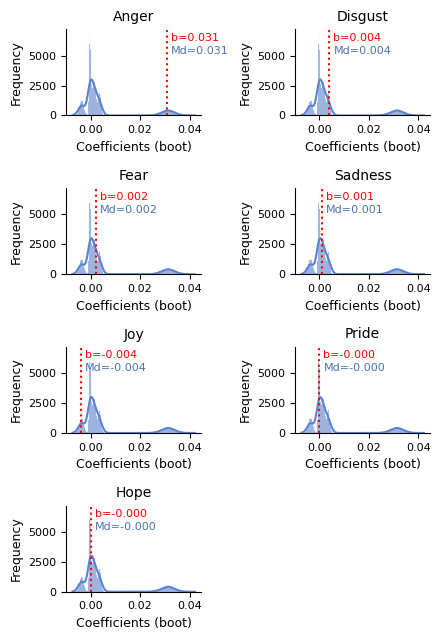

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(4.5, 6.5),
                        #sharex=True, 
                        #sharey=True
                        )

for i, emotion in enumerate(replies_coeffs["DV"].unique()):
    coeff_row = replies_coeffs[replies_coeffs["DV"]==emotion]
    coeff = float(coeff_row["Estimate"].values[0])
    coeff = float(coeff)
    p_value = coeff_row["p"].values[0]
    df = replies_coeffs_boot[replies_coeffs_boot["DV"] == emotion]
    median = df["Coefficient_boot"].median()
    mean = df["Coefficient_boot"].mean()
    sns.histplot(replies_coeffs_boot["Coefficient_boot"], 
                 ax=ax[i//2, i%2], color="#5A83D1", edgecolor="#4C72B0", kde=True)
    ax[i//2, i%2].set_title(emotion, fontsize=10)
    ax[i//2, i%2].set_xlabel("Coefficients (boot)", fontsize=9)
    ax[i//2, i%2].set_ylabel("Frequency", fontsize=9)
    ax[i//2, i%2].tick_params(axis="x", labelsize=8)
    ax[i//2, i%2].tick_params(axis="y", labelsize=8)
    ax[i//2, i%2].axvline(x=coeff,
                            color="red",
                            linestyle=":")
    
    ax[i // 2, i % 2].text(
        coeff + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.9,
        f"b={coeff:.3f}", 
        color="red", 
        fontsize=8,
        verticalalignment='center'
    )

    ax[i // 2, i % 2].text(
        coeff + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.75,
        f"Md={median:.3f}", 
        color="#4C72B0", 
        fontsize=8,
        verticalalignment='center'
    )

    custom_plots(ax=ax[i//2, i%2])

    # hide the last plot
    if i == 6:
        ax[3, 1].axis("off")


plt.tight_layout()


plt.savefig(join("./replies/", "replies_boot.pdf"), dpi=300)
plt.savefig(join(FIG_DIR, "replies_boot.pdf"), dpi=300)
plt.show()

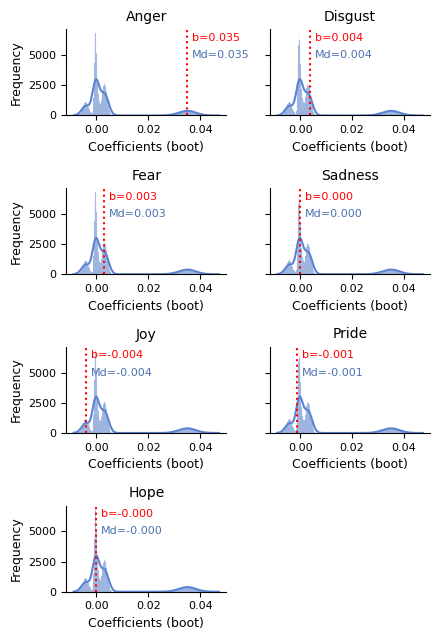

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(4.5, 6.5),
                        sharex=False, sharey=True)

for i, emotion in enumerate(first_coeffs["DV"].unique()):
    coeff_row = first_coeffs[first_coeffs["DV"]==emotion]
    coeff = float(coeff_row["Estimate"].values[0])
    p_value = coeff_row["p"].values[0]
    df = first_coeffs_boot[first_coeffs_boot["DV"] == emotion]
    median = df["Coefficient_boot"].median()
    mean = df["Coefficient_boot"].mean()
    sns.histplot(first_coeffs_boot["Coefficient_boot"], 
                 ax=ax[i//2, i%2], color="#5A83D1", edgecolor="#4C72B0", kde=True)
    ax[i//2, i%2].set_title(emotion, fontsize=10)
    ax[i//2, i%2].set_xlabel("Coefficients (boot)", fontsize=9)
    ax[i//2, i%2].set_ylabel("Frequency", fontsize=9)
    ax[i//2, i%2].tick_params(axis="both", labelsize=8)
    ax[i//2, i%2].axvline(x=coeff,
                            color="red",
                            linestyle=":")
    
    ax[i // 2, i % 2].text(
        coeff + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.9,
        f"b={coeff:.3f}", 
        color="red", 
        fontsize=8,
        verticalalignment='center'
    )

    ax[i // 2, i % 2].text(
        coeff + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.7,
        f"Md={median:.3f}", 
        color="#4C72B0", 
        fontsize=8,
        verticalalignment='center')
    
    custom_plots(ax=ax[i//2, i%2])
    
    # hide the last plot
    if i == 6:
        ax[3, 1].axis("off")

plt.tight_layout()

plt.savefig(join("./replies/" , 
                 "replies_first_boot.pdf"), 
                 bbox_inches="tight", 
                 dpi=300)

plt.savefig(join(FIG_DIR, 
                 "replies_first_boot.pdf"), 
                 bbox_inches="tight", 
                 dpi=300)
plt.show()